In [13]:
import pandas as pd
import os
import numpy as np

data_path = os.path.join("eDo", "data", "01.csv")
df = pd.read_csv(data_path, parse_dates=['DateTime'], index_col='DateTime')

df = df.dropna()
print(df.head())


                         Open      High       Low     Close      Volume  \
DateTime                                                                  
2022-01-25 13:00:00  36519.12  36579.99  36259.10  36498.00  2008.17575   
2022-01-25 14:00:00  36497.39  37149.42  36252.00  36299.99  5493.26524   
2022-01-25 15:00:00  36299.99  36780.00  35967.33  36530.00  3943.20294   
2022-01-25 16:00:00  36530.00  37086.64  36492.48  36837.70  2613.07831   
2022-01-25 17:00:00  36837.70  37481.75  36800.00  37273.33  3299.07838   

                      log_ret  fracdiff  
DateTime                                 
2022-01-25 13:00:00 -0.000579  0.103441  
2022-01-25 14:00:00 -0.005440  0.097746  
2022-01-25 15:00:00  0.006316  0.107048  
2022-01-25 16:00:00  0.008388  0.112089  
2022-01-25 17:00:00  0.011756  0.118196  


In [14]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df  = df.iloc[train_size:].copy()

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 12373, Test size: 3094


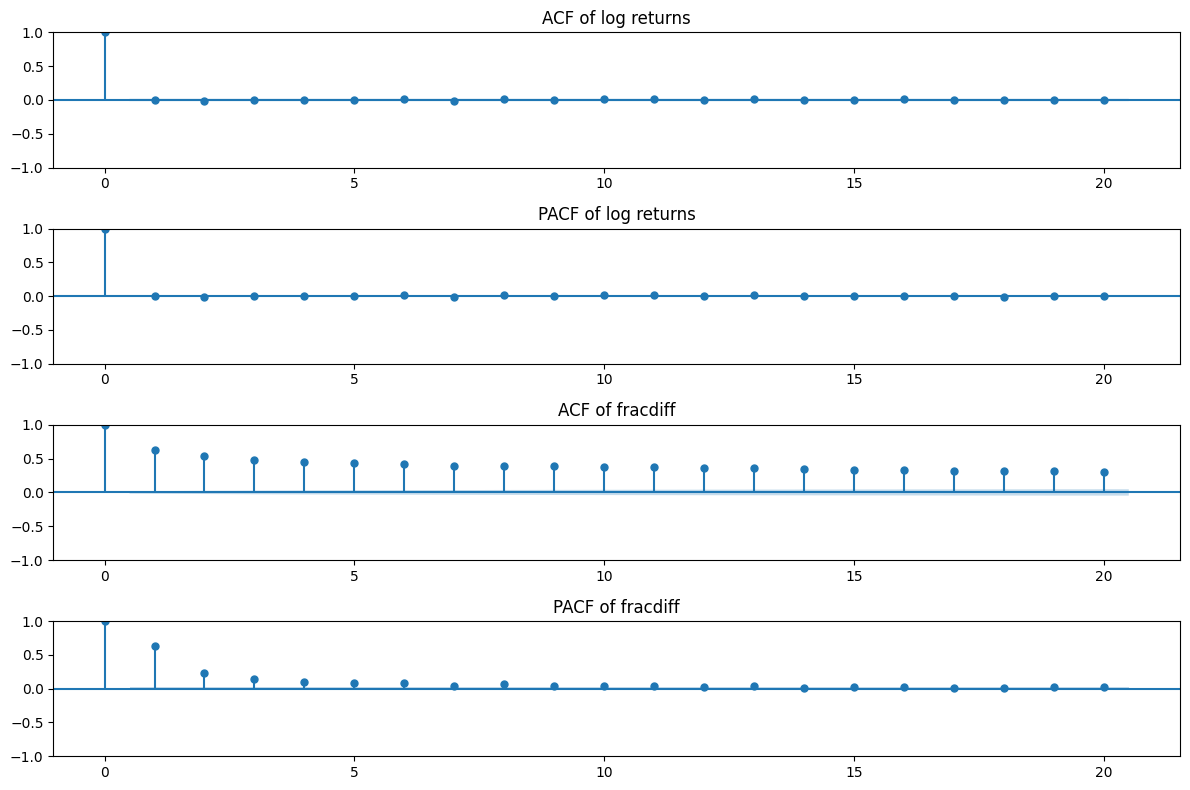

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(12, 8))

plot_acf(train_df['log_ret'], ax=axes[0], lags=20, title="ACF of log returns")
plot_pacf(train_df['log_ret'], ax=axes[1], lags=20, title="PACF of log returns")
plot_acf(train_df['fracdiff'], ax=axes[2], lags=20, title="ACF of fracdiff")
plot_pacf(train_df['fracdiff'], ax=axes[3], lags=20, title="PACF of fracdiff")
plt.tight_layout()
plt.show()


In [16]:
from pmdarima import auto_arima

stepwise_model_logret = auto_arima(
    train_df['log_ret'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=0,           # because we assume log_ret is already differenced
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model_logret.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-90413.563, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-90417.536, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-90415.536, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-90415.536, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-90415.600, Time=1.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.750 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                12373
Model:                        SARIMAX   Log Likelihood               45209.768
Date:                Sat, 04 Jan 2025   AIC                         -90417.536
Time:                        20:27:00   BIC                         -90410.112
Sample:                    01-25-2022   HQIC                        -90415.049
                         - 06-25-2023                             

In [17]:
stepwise_model_fracdiff = auto_arima(
    train_df['fracdiff'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=0,           # because its already fractionally differenced
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model_fracdiff.summary())


Performing stepwise search to minimize aic


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-89680.804, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-21933.312, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-37443.070, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-90200.187, Time=1.42 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-88815.111, Time=1.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-89757.001, Time=0.85 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-89879.995, Time=0.93 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-89945.325, Time=0.99 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-89936.645, Time=8.33 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 16.941 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Obse

In [18]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = (2, 0, 1)
fracdiff_model = ARIMA(train_df['fracdiff'], order=(p, d, q)).fit()
print(fracdiff_model.summary())

p, d, q = (0, 0, 0)
log_ret_model = ARIMA(train_df['log_ret'], order=(p, d, q)).fit()
print(log_ret_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               fracdiff   No. Observations:                12373
Model:                 ARIMA(2, 0, 1)   Log Likelihood               45094.766
Date:                Sat, 04 Jan 2025   AIC                         -90179.533
Time:                        20:27:19   BIC                         -90142.416
Sample:                    01-25-2022   HQIC                        -90167.101
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0994      0.000    293.655      0.000       0.099       0.100
ar.L1          1.0915      0.013     80.873      0.000       1.065       1.118
ar.L2         -0.1532      0.011    -14.397      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:465: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                12373
Model:                          ARIMA   Log Likelihood               45209.790
Date:                Sat, 04 Jan 2025   AIC                         -90415.580
Time:                        20:27:22   BIC                         -90400.734
Sample:                    01-25-2022   HQIC                        -90410.607
                         - 06-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.932e-05   5.64e-05     -0.343      0.732      -0.000    9.13e-05
sigma2       3.93e-05   1.77e-07    222.415      0.000     3.9e-05    3.96e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:612: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


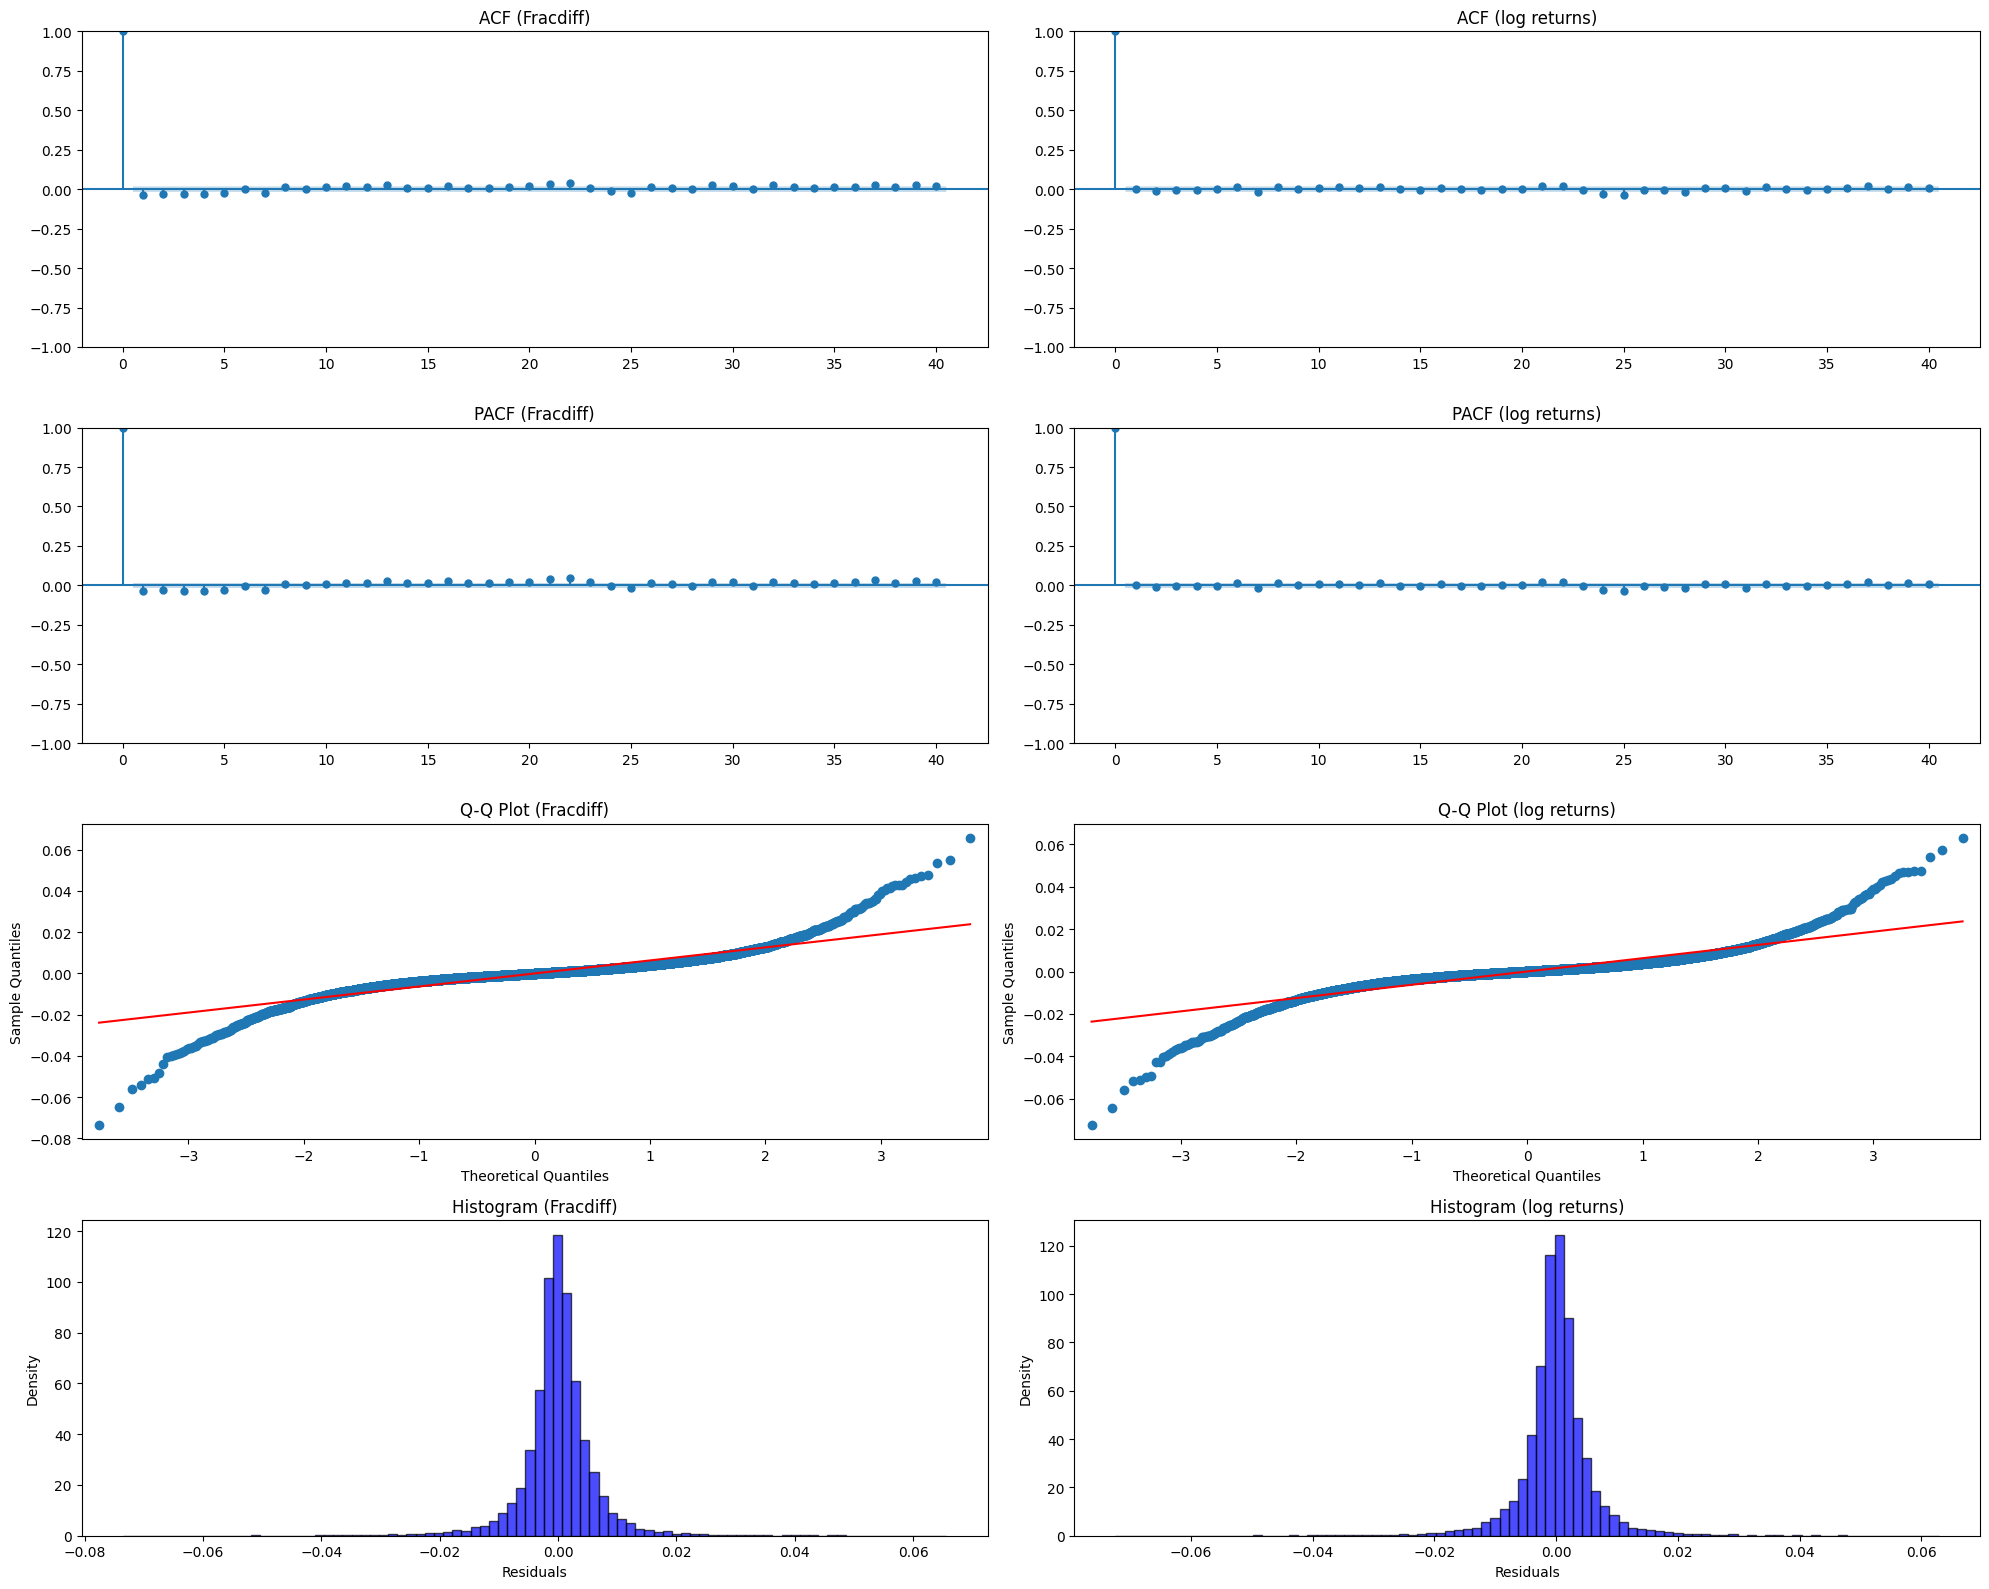

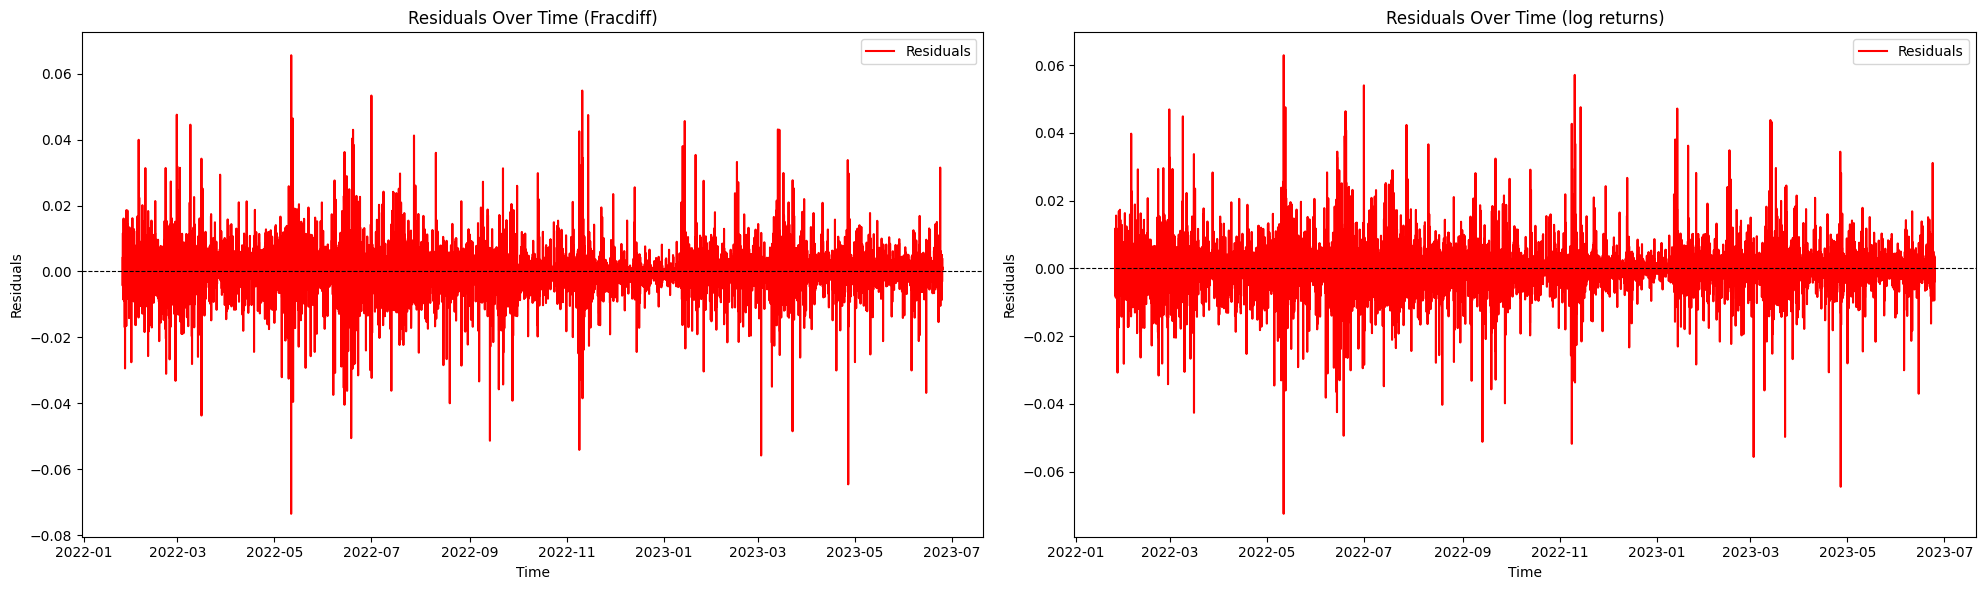

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

residuals_fracdiff = fracdiff_model.resid
residuals_log_ret = log_ret_model.resid.dropna()

fig, axes = plt.subplots(4, 2, figsize=(20, 16))

# ACF and PACF for Fracdiff residuals
plot_acf(residuals_fracdiff, ax=axes[0, 0], lags=40, title="ACF (Fracdiff)")
plot_pacf(residuals_fracdiff, ax=axes[1, 0], lags=40, title="PACF (Fracdiff)")

# ACF and PACF for log returns residuals
plot_acf(residuals_log_ret, ax=axes[0, 1], lags=40, title="ACF (log returns)")
plot_pacf(residuals_log_ret, ax=axes[1, 1], lags=40, title="PACF (log returns)")

# Q-Q Plots
sm.qqplot(residuals_fracdiff, line='s', ax=axes[2, 0])
axes[2, 0].set_title("Q-Q Plot (Fracdiff)")
sm.qqplot(residuals_log_ret, line='s', ax=axes[2, 1])
axes[2, 1].set_title("Q-Q Plot (log returns)")

# Residual Histograms
axes[3, 0].hist(residuals_fracdiff, bins=90, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[3, 0].set_title("Histogram (Fracdiff)")
axes[3, 0].set_xlabel("Residuals")
axes[3, 0].set_ylabel("Density")

axes[3, 1].hist(residuals_log_ret, bins=90, density=True, alpha=0.7, color='blue', edgecolor='black')
axes[3, 1].set_title("Histogram (log returns)")
axes[3, 1].set_xlabel("Residuals")
axes[3, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Residual Time Series Plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Residuals over time for Fracdiff
axes[0].plot(residuals_fracdiff, label='Residuals', color='red')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title("Residuals Over Time (Fracdiff)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Residuals")
axes[0].legend()

# Residuals over time for log returns
axes[1].plot(residuals_log_ret, label='Residuals', color='red')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title("Residuals Over Time (log returns)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Residuals")
axes[1].legend()

plt.tight_layout()
plt.show()


# GARCH

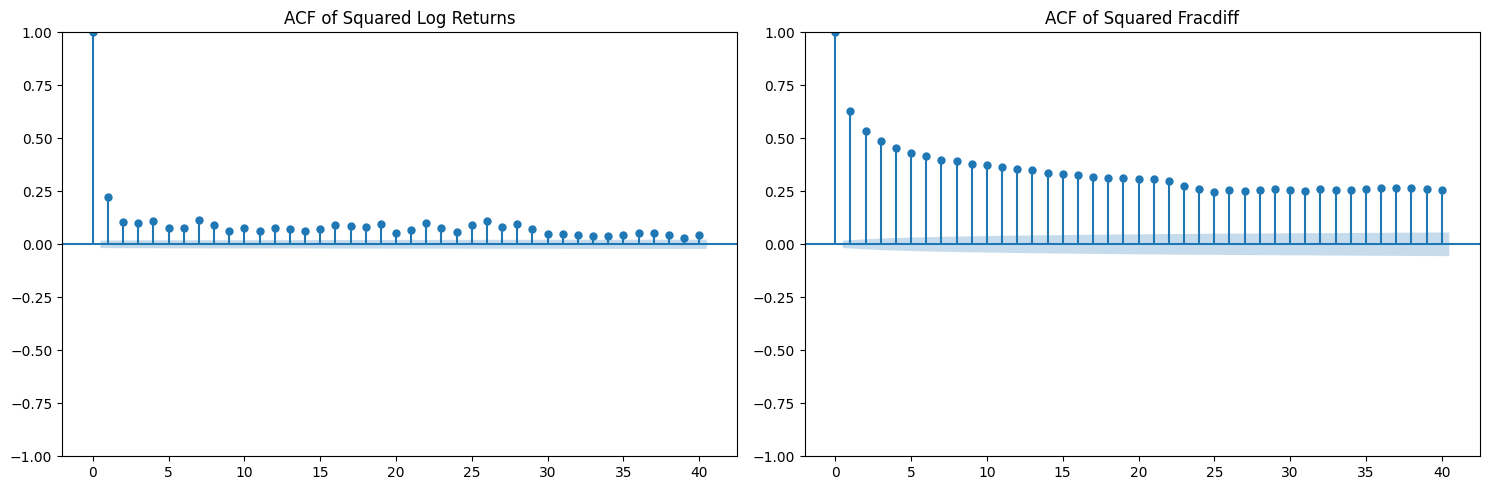

In [20]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(train_df['log_ret']**2, lags=40, 
         title="ACF of Squared Log Returns", ax=axes[0])

plot_acf(train_df['fracdiff']**2, lags=40, 
         title="ACF of Squared Fracdiff", ax=axes[1])

plt.tight_layout()
plt.show()


This means the volatility has tendency to cluster and is present for some time after an event.

In [21]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(train_df['fracdiff'])
# arch_test returns (LM stat, LM p-value, F-stat, F p-value)
print("ARCH test:", arch_test)

arch_test = het_arch(train_df['log_ret'])
print("ARCH test:", arch_test)


ARCH test: (5684.996101152077, 0.0, 1051.5278652883815, 0.0)
ARCH test: (911.1998816453887, 2.4740270407517e-189, 98.28272255681819, 8.019400539957793e-197)


# ARIMA + GARCH

In [22]:
import itertools
from arch import arch_model

best_aic = np.inf
best_order = None
best_model = None

p_range = range(1, 6)
q_range = range(1, 6)

arima_resid  = fracdiff_model.resid.dropna()*100

for p, q in itertools.product(p_range, q_range):

        model = arch_model(arima_resid, mean='Zero', vol='GARCH', p=p, q=q)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (p, q)
            best_model = res

print(f"Best GARCH model order: p={best_order[0]}, q={best_order[1]} with AIC={best_aic}")
print(best_model.summary())


Best GARCH model order: p=1, q=5 with AIC=20283.122070845075
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10134.6
Distribution:                  Normal   AIC:                           20283.1
Method:            Maximum Likelihood   BIC:                           20335.1
                                        No. Observations:                12373
Date:                Sat, Jan 04 2025   Df Residuals:                    12373
Time:                        20:27:24   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
--------------------------------------------------------------------------

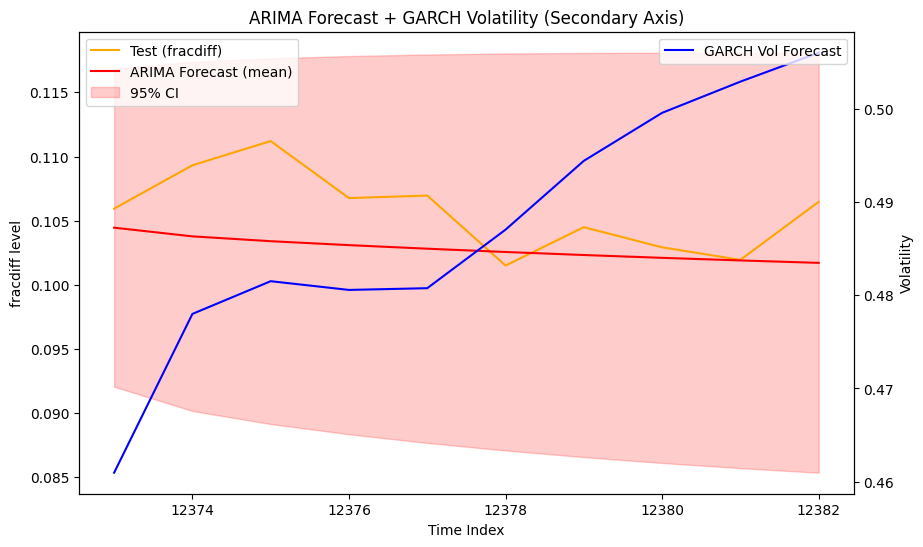

In [23]:
n_test = 10

# ARIMA forecast object
forecast_obj = fracdiff_model.get_forecast(steps=n_test)

# ARIMA point forecast (mean)
arima_mean_pred = forecast_obj.predicted_mean

# Confidence intervals for ARIMA forecast
arima_conf_int = forecast_obj.conf_int(alpha=0.05)  
# alpha=0.05 for 95% CI (the default), returns a DataFrame with columns ['lower fracdiff', 'upper fracdiff']

# You can extract them for plotting (assuming the column name is 'lower fracdiff' / 'upper fracdiff'):
lower_ci = arima_conf_int.iloc[:, 0]
upper_ci = arima_conf_int.iloc[:, 1]

# GARCH forecast
garch_vol_forecast = best_model.forecast(horizon=n_test, reindex=False)
out_of_sample_vol = garch_vol_forecast.variance.values[-1,:] ** 0.5  # sqrt of variance

fig, ax1 = plt.subplots(figsize=(10,6))

# --- Left axis for ARIMA forecast, actual data, etc. --- #
ax1.set_title("ARIMA Forecast + GARCH Volatility (Secondary Axis)")

# Plot test data
ax1.plot(
    np.arange(train_size, train_size + n_test),
    test_df['fracdiff'].values[:n_test],
    label='Test (fracdiff)',
    color='orange'
)

# Plot the ARIMA mean forecast
ax1.plot(
    np.arange(train_size, train_size + n_test),
    arima_mean_pred,
    label='ARIMA Forecast (mean)',
    color='red'
)

# Plot the ARIMA confidence interval
ax1.fill_between(
    np.arange(train_size, train_size + n_test),
    lower_ci,
    upper_ci,
    color='red',
    alpha=0.2,
    label='95% CI'
)

ax1.set_xlabel("Time Index")
ax1.set_ylabel("fracdiff level")  # or an appropriate label
ax1.legend(loc='upper left')

# --- Right axis for GARCH volatility --- #
ax2 = ax1.twinx()

# Plot out-of-sample GARCH volatility forecast
ax2.plot(
    np.arange(train_size, train_size + n_test),
    out_of_sample_vol,
    label="GARCH Vol Forecast",
    color='blue'
)

ax2.set_ylabel("Volatility")
ax2.legend(loc='upper right')

plt.show()


# TODO
- finish rolling window arima+garch